In [20]:
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [21]:
def grab_matrices(cq_file,nbasis):
    ''' Grabs the rotated density matrices and rotation angles 
        from a PHF output file from Chronus
    '''
    
    # determine the total number of grid points
    search_file = open(cq_file, "r")
    for line in search_file:
        if 'LebedevTrap Grid' in line:
            contents = re.split('\s+|\(|\)|\,',line)
            ngridT = int(contents[5])*int(contents[6])
    search_file.close()

    read_den = False
    angles, ang_dict = [], {}
    quaterions = ['Scalar', 'Mz', 'My', 'Mx']
    factor, ang_count, den_count, quat_ind = 1, -1, 0, 0
    den_arrays = np.zeros([ngridT,4,nbasis*nbasis],dtype=complex)
    search_file = open(cq_file, "r")
    for line in search_file:

        # collect the angles in a list of dictionaries
        if 'Alpha' in line:
            ang_dict = {}
            contents = re.split('\s+',line)
            ang_dict['alpha'] = float(contents[2])
        if 'Beta' in line:
            contents = re.split('\s+',line)
            ang_dict['beta'] = float(contents[2])
        if 'Gamma' in line:
            contents = re.split('\s+',line)
            ang_dict['gamma'] = float(contents[2])
            angles.append(ang_dict)
            ang_count += 1

        # determine what kind of density we're grabbing
        if 'Rot Density' in line:
            contents = re.split('\s+|\(|\)',line)
            quat_ind = quaterions.index(contents[3])
            if 'Re' in line:
                factor = 1
            else:
                factor = 1j
 
        # Grab densities from the output file
        if '-----' in line:
            read_den = not read_den
        if read_den:
            contents = re.split('\s+|--+',line)
            for element in contents:
                if 'e+' in element or 'e-' in element:
                    den_arrays[ang_count,quat_ind,den_count] += factor*float(element)
                    den_count += 1
        if not read_den:
            den_count = 0 

    search_file.close()

    # redimension the rot densities into matrices
    rot_dens = np.zeros([ngridT,4,nbasis,nbasis],dtype=complex)
    for g in range(ngridT):
        for q in range(4):
            ij = 0
            for i in range(nbasis):
                for j in range(nbasis):
                    rot_dens[g,q,i,j] = den_arrays[g,q,ij]
                    ij += 1                        

    # make list of angle labels
    ang_list = []
    for g in range(ngridT):
        string = "(%.2f,%.2f,%.2f)" % (angles[g]['alpha'], angles[g]['beta'], angles[g]['gamma'])
        ang_list.append(string)
        
#   print "rot den = \n", rot_dens[1,1].real
#   print angles[1]['alpha']

    return ngridT, angles, ang_list, rot_dens

In [22]:
cq_file = 'h3-sto3g-read-dense.out' 
nbasis  = 3
ngridT, angles, ang_list, rot_dens = grab_matrices(cq_file,nbasis)

In [23]:
def euc_distance(rot_dens,ngridT):
    ''' Calculates the Euclidean distance between all the rotated densities
        and stores them in the matrix dist
    '''

    # calculate the euclidean distance between all rotated densities
    min_dist = []
    dist = np.zeros([4,ngridT,ngridT])
    for q in range(4):
        for g in range(ngridT):
            dist_min = 1000.
            dist_ind = g
            for h in range(g):
#               adiff = angles[g]['alpha'] - angles[h]['alpha']
#               bdiff = angles[g]['beta']  - angles[h]['beta']
#               gdiff = angles[g]['gamma'] - angles[h]['gamma']
                dist[q,g,h] = np.linalg.norm(rot_dens[g,q]-rot_dens[h,q],'fro')
                if abs(dist[q,g,h]) < dist_min and g!=h:
                    dist_min = dist[q,g,h]
                    dist_ind = h
            if (g,dist_ind) not in min_dist and (dist_ind,g) not in min_dist:
                min_dist.append((g,dist_ind)) 
        dist[q] /= np.max(dist[q])

    return dist

In [24]:
def plot_euc_heatmap(dist):
    ''' Plots a heatmap of the Euclidean distances between rotated densities '''
    
    fig = plt.figure()

    plt.subplot(221)
    plt.imshow(dist[0], cmap='Blues', interpolation='nearest')
    plt.title("Scalar P")
    plt.colorbar()

    plt.subplot(222)
    plt.imshow(dist[1], cmap='Blues', interpolation='nearest')
    plt.title("Mz P")
    plt.colorbar()

    plt.subplot(223)
    plt.imshow(dist[2], cmap='Blues', interpolation='nearest')
    plt.title("My P")
    plt.colorbar()

    plt.subplot(224)
    plt.imshow(dist[3], cmap='Blues', interpolation='nearest')
    plt.title("Mx P")
    plt.colorbar()

    plt.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>


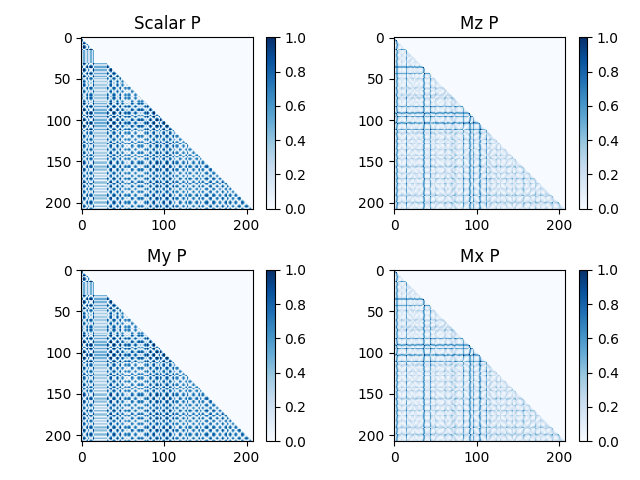

In [25]:
dist = euc_distance(rot_dens,ngridT)
plot_euc_heatmap(dist)

In [26]:
def plot_sphere_heatmap(dist,angles,ngridT,g_angle):
    ''' Plots the differences between rotated densities on a sphere '''

    plot_axis = 1
    nplots    = plot_axis**2
    nmod = int(26/nplots)
    thresh  = 1.e-3

    fig = plt.figure()

    # plot a unit sphere
    phi = np.linspace(0, 2 * np.pi, 26)
    theta = np.linspace(0, np.pi, 26)
    x = np.outer(np.cos(phi), np.sin(theta))
    y = np.outer(np.sin(phi), np.sin(theta))
    z = np.outer(np.ones(np.size(phi)), np.cos(theta))

    # define list of alpha/beta combinations to plot for a given gamma
    icount = 1
    ab_angs = []
    for g, angle in enumerate(angles):
        if abs(angle['gamma']-g_angle) < thresh:
            if icount % nmod == 0:
                ab_angs.append((angle['alpha'],angle['beta']))
            icount += 1
  
    icount = 1
    for a_angle, b_angle in ab_angs:
        ax = fig.add_subplot(plot_axis,plot_axis,icount, projection='3d')
        ax.plot_surface(x, y, z, color='b',alpha=0.1)

        # define cartesian coordinates for alpha/beta with fixed gamma
        theta, phi = [], []
        for g, angle in enumerate(angles):
            if abs(angle['gamma']-g_angle) < thresh:
                phi.append(angle['alpha'])
                theta.append(angle['beta'])
        npoints = len(theta)
        xx = np.zeros([npoints])
        yy = np.zeros([npoints])
        zz = np.zeros([npoints])
        for i in range(npoints):
            if abs(phi[i] - a_angle) < thresh and abs(theta[i] - b_angle) < thresh:
                index = i
            xx[i] = np.sin(theta[i]) * np.cos(phi[i])
            yy[i] = np.sin(theta[i]) * np.sin(phi[i])
            zz[i] = np.cos(theta[i])
    
        # define difference color map for a fixed angle
        distances, d_index = [], []
        for g in range(ngridT):
            adiff = abs(angles[g]['alpha'] - a_angle)
            bdiff = abs(angles[g]['beta']  - b_angle)
            gdiff = abs(angles[g]['gamma'] - g_angle)
            if adiff < thresh and bdiff < thresh and gdiff < thresh:
                for h in range(ngridT):
                    gdiff = abs(angles[h]['gamma'] - g_angle)
                    if gdiff < thresh:
                        distances.append(dist[0,g,h])
                        d_index.append(h)

        v0 = np.sin(b_angle) * np.cos(a_angle)
        v1 = np.sin(b_angle) * np.sin(a_angle)
        v2 = np.cos(b_angle)
#       print a_angle, b_angle, g_angle, v0, v1, v2
        for g in range(len(distances)):
            angle = angles[d_index[g]]
            v0 = np.sin(angle['beta']) * np.cos(angle['alpha'])
            v1 = np.sin(angle['beta']) * np.sin(angle['alpha'])
            v2 = np.cos(angle['beta'])
#           print distances[g], angle, v0, v1, v2
        # plot lebedev points on sphere colored by Euclidean distances
        ax.set_title('(%.4f,%.4f,%.4f)' %(a_angle, b_angle, g_angle))
        ax.scatter(xx,yy,zz,c=distances,s=100,cmap='gray')
        ax.scatter(xx[index],yy[index],zz[index],color='red',s=200)
        ax.set_xlim([-1,1])
        ax.set_ylim([-1,1])
        ax.set_zlim([-1,1])
        ax.set_aspect("equal")
        ax.set_xlabel('X axis')
        ax.set_ylabel('Y axis')
        ax.set_zlabel('Z axis')

        icount += 1

    plt.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>


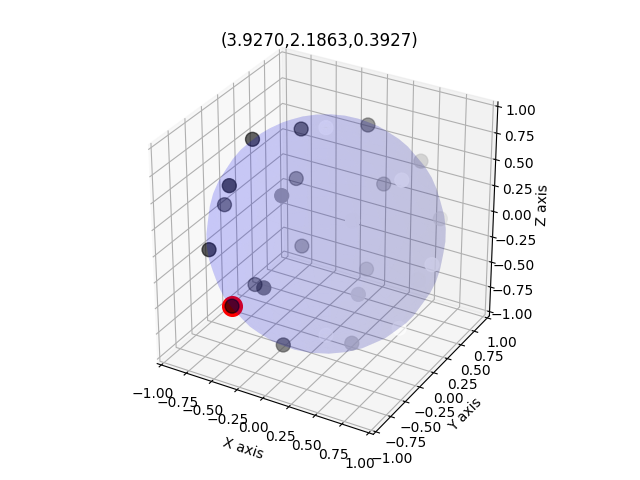

In [27]:
g_angle = 0.392699082 
plot_sphere_heatmap(dist,angles,ngridT,g_angle)

In [28]:
def find_path_from_angles(dist,angles,ngridT,g_angle):
    ''' Tries to find a path through the densities by moving to the next
        closest angle. '''

    thresh  = 1.e-3

    # plot alpha/beta combinations for a given gamma
    ab_angs, ang_ind = [], []
    for g, angle in enumerate(angles):
        if abs(angle['gamma']-g_angle) < thresh:
            ab_angs.append((angle['alpha'],angle['beta']))
            ang_ind.append(g)
    npoints = len(ab_angs)

    # determine paths through the grid points
    icount = 0
    total_dist = 0.
    path = np.zeros([3,npoints])
    ang_path = [ab_angs[0]]
    v1, v2 = np.zeros([3]), np.zeros([3])
    while icount < 25:
        a_angle = ang_path[icount][0]
        b_angle = ang_path[icount][1]

        # define current cartesian point
        v1[0] = np.sin(b_angle) * np.cos(a_angle)
        v1[1] = np.sin(b_angle) * np.sin(a_angle)
        v1[2] = np.cos(b_angle)
        if icount == 0:
            path[0,icount], path[1,icount], path[2,icount] = v1[0], v1[1], v1[2]

        # find the shortest distance to the next one (not already in path)
        ind_ang = 0
        min_dist = 1000.
        for a2_angle, b2_angle in ab_angs:
            v2[0] = np.sin(b2_angle) * np.cos(a2_angle)
            v2[1] = np.sin(b2_angle) * np.sin(a2_angle)
            v2[2] = np.cos(b2_angle)
            found_dist = np.linalg.norm(v1-v2)
            if found_dist < min_dist and (a2_angle, b2_angle) not in ang_path:
                min_dist = found_dist
                euc_dist = dist[0,ang_ind[ind_ang],icount]
                min_angs = (a2_angle,b2_angle)
                path[0,icount+1], path[1,icount+1], path[2,icount+1] = v2[0], v2[1], v2[2]
            ind_ang += 1
        total_dist += euc_dist
        ang_path.append(min_angs)
        icount += 1

    return path, total_dist

def find_path_from_dist(dist,angles,ngridT,g_angle):
    ''' Tries to find a path through the densities by moving to the next
        density with the closest Euclidean distance. '''

    thresh  = 1.e-3

    # plot alpha/beta combinations for a given gamma
    ab_angs, ang_ind = [], []
    for g, angle in enumerate(angles):
        if abs(angle['gamma']-g_angle) < thresh:
            ab_angs.append((angle['alpha'],angle['beta']))
            ang_ind.append(g)
    npoints = len(ab_angs)
 
    # determine paths through the grid points based on density diffs.
    icount = 0
    total_dist = 0.
    path = np.zeros([3,npoints])
    ang_path = [ab_angs[0]]
    v1, v2 = np.zeros([3]), np.zeros([3])
    while icount < 25:
        a_angle = ang_path[icount][0]
        b_angle = ang_path[icount][1]

        # define current cartesian point
        v1[0] = np.sin(b_angle) * np.cos(a_angle)
        v1[1] = np.sin(b_angle) * np.sin(a_angle)
        v1[2] = np.cos(b_angle)
        if icount == 0:
            path[0,icount], path[1,icount], path[2,icount] = v1[0], v1[1], v1[2]

#       # find the shortest distance to the next one (not already in path)
        ind_ang = 0
        min_dist = 1000.
        for a2_angle, b2_angle in ab_angs:
            v2[0] = np.sin(b2_angle) * np.cos(a2_angle)
            v2[1] = np.sin(b2_angle) * np.sin(a2_angle)
            v2[2] = np.cos(b2_angle)
            found_dist = dist[0,ang_ind[ind_ang],icount]
            if found_dist < min_dist and (a2_angle, b2_angle) not in ang_path:
                min_dist = found_dist
                min_angs = (a2_angle,b2_angle)
                path[0,icount+1], path[1,icount+1], path[2,icount+1] = v2[0], v2[1], v2[2]
            ind_ang += 1
        total_dist += min_dist
        ang_path.append(min_angs)
        icount += 1

    return path, total_dist

In [29]:
def plot_paths(a_path,d_path,angles):
    ''' Plot paths along a sphere as determined in other routines. '''

    thresh = 1.e-3
    fig = plt.figure()

    # plot a unit sphere
    phi = np.linspace(0, 2 * np.pi, 50)
    theta = np.linspace(0, np.pi, 50)
    x = np.outer(np.cos(phi), np.sin(theta))
    y = np.outer(np.sin(phi), np.sin(theta))
    z = np.outer(np.ones(np.size(phi)), np.cos(theta))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x, y, z, color='b',alpha=0.1)

    # plot alpha/beta combinations for a given gamma
    ab_angs, ang_ind = [], []
    for g, angle in enumerate(angles):
        if abs(angle['gamma']-g_angle) < thresh:
            ab_angs.append((angle['alpha'],angle['beta']))
            ang_ind.append(g)
    npoints = len(ab_angs)
    xx, yy, zz = np.zeros([npoints]), np.zeros([npoints]), np.zeros([npoints])
    for i, angle in enumerate(ab_angs):
        xx[i] = np.sin(angle[1]) * np.cos(angle[0])
        yy[i] = np.sin(angle[1]) * np.sin(angle[0])
        zz[i] = np.cos(angle[1])
    ax.scatter(xx,yy,zz,color='b',s=100)
    ax.scatter(xx[0],yy[0],zz[0],color='red',s=200)

    ax.plot(a_path[0],a_path[1],a_path[2])
    ax.plot(d_path[0],d_path[1],d_path[2])

    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    ax.set_zlim([-1,1])
    ax.set_aspect('equal')
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    plt.tight_layout()
    plt.title("Gamma = %.4f" % g_angle)
#   plt.show()


Gamma      =  0.392699082
Angle-Dist =  9.24539388734
Euc-Dist   =  3.26723379186


<IPython.core.display.Javascript object>


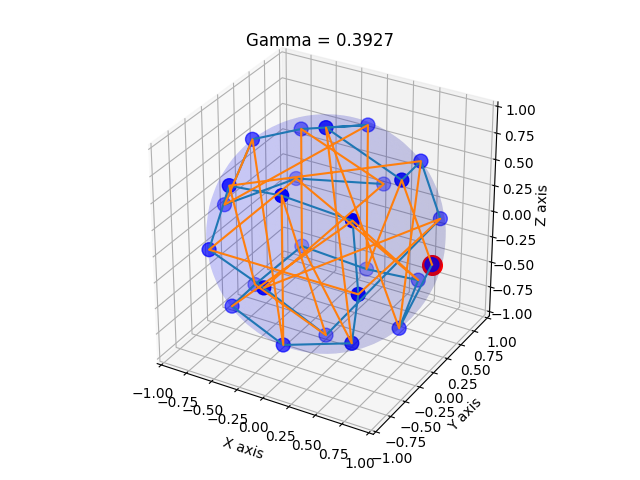


Gamma      =  1.17809725
Angle-Dist =  8.34165766251
Euc-Dist   =  1.9155744223


<IPython.core.display.Javascript object>


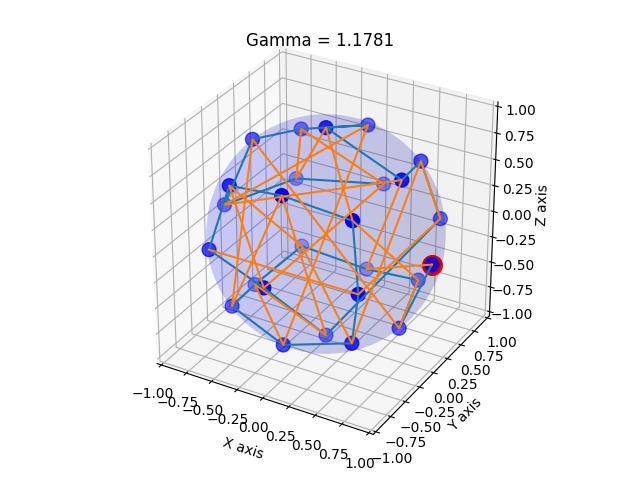

In [30]:
g_angle = 0.392699082 
a_path, total_dist1 = find_path_from_angles(dist,angles,ngridT,g_angle)
d_path, total_dist2 = find_path_from_dist(dist,angles,ngridT,g_angle)
print "Gamma      = ", g_angle
print "Angle-Dist = ", total_dist1
print "Euc-Dist   = ", total_dist2
plot_paths(a_path,d_path,angles)

g_angle = 1.17809725
a_path, total_dist1 = find_path_from_angles(dist,angles,ngridT,g_angle)
d_path, total_dist2 = find_path_from_dist(dist,angles,ngridT,g_angle)
print "\nGamma      = ", g_angle
print "Angle-Dist = ", total_dist1
print "Euc-Dist   = ", total_dist2
plot_paths(a_path,d_path,angles)

plt.show()